# Deep Learning project - Differentiable Search Index
### Ludovico Comito - Matr. 1837155
### Giulio Fedeli - Matr. 1873677
### Lorenzo Cirone - Matr. 1930811

## Introduction
In the modern landscape of the Information Retrieval approach, one of the most interesting solutions was published in the paper "*Transformer Memory as a Differentiable Search Index*", where an encoder-decoder architecture is trained in a multitask fashion to perform both indexing and retrieval at the same time. \\
With this project, we explore solutions based on the same DSI concept, but exploring new architectures and training approaches. \

**This notebook starts from the model training, that you can fully reproduce within the notebook, then illustrates the implementation of the baseline and finally the dataset preprocessing. **

## Model training
The following code allows to fully reproduce the training of our proposed models (no need to execute the previous cells). All the datasets splits are made available via wget and can be downloaded straight from this notebook (or can be found in [this repository](https://github.com/ludocomito/Deep-Learning-Project/tree/main/dataset)).\
*The execution of the custom encoder-decoder or Lamini Flan T5 can be controlled by the custom_enc_dec variable in the parameters dict*.

Install the required dependencies:

In [ ]:
!pip install transformers lightning wandb --quiet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset

import transformers
from transformers import AutoTokenizer, AutoModel
from transformers import AutoTokenizer, T5ForConditionalGeneration
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import BertTokenizer, EncoderDecoderModel


import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint

import wandb
import pandas as pd
import numpy as np
import os
import json
import random
import pickle

Download train, validation and test datasets files via wget:

In [ ]:
'''
set to 'standard' to download the standard dataset or
'qg' to use the query generation one.
'''
training_dataset_type = 'standard'

In [ ]:
if training_dataset_type == 'standard':
    !wget -O training_dataset.pkl https://github.com/ludocomito/Deep-Learning-Project/raw/main/dataset/training_dataset.pkl
else:
    !wget -O training_dataset.pkl https://github.com/ludocomito/Deep-Learning-Project/raw/main/dataset/qg_training_dataset.pkl

In [ ]:
!wget -O validation_queries.pkl https://github.com/ludocomito/Deep-Learning-Project/raw/main/dataset/validation/processed_val_queries.pkl
!wget -O validation_rankings.pkl https://github.com/ludocomito/Deep-Learning-Project/raw/main/dataset/validation/val_top_10.pkl
!wget -O test_queries.pkl https://github.com/ludocomito/Deep-Learning-Project/raw/main/dataset/test/processed_test_queries.pkl
!wget -O test_rankings.pkl https://github.com/ludocomito/Deep-Learning-Project/raw/main/dataset/test/test_top_10.pkl

In the following dictionary are defined all the parameters and hyperparameters for training.

In [ ]:
parameters_dict = {
  'training_data_path': 'training_dataset.pkl',
  'val_queries_path': 'validation_queries.pkl',
  'val_ranking_path': 'validation_rankings.pkl',
  'test_queries_path': 'test_queries.pkl',
  'test_ranking_path': 'test_rankings.pkl',
  'num_tokens': 32, # numer of tokens to take from each document
  'batch_size': 32, # 32 or 64
  'num_epochs': 5,
  'learning_rate':0.0005, # 0.0005 or 0.0001
  'model_name': 'MBZUAI/LaMini-Flan-T5-248M', # or google-t5/t5-base
  'encoder_name': 'bert-base-uncased', # custom encoder
  'decoder_name':'gpt2', # custom decoder
  'custom_enc_dec': False, # use custom or regular version of the model
  'run_name': 'experiment_name', # name for wandb run
  'debug_mode': True, # False if you want to log (wandb credentials needed)
  'checkpoint_dir': ''
}

Execute ONLY if you want to log

In [ ]:
if not parameters_dict['debug_mode']:
    !wandb login

In [ ]:
# start a new wandb run if not in debug mode
if not parameters_dict['debug_mode']:
    wandb.init(
        project='NEW_deep_learning',
        name = parameters_dict['run_name'],
        config=parameters_dict,
        entity='_team_'
    )

Training data contains indexing data for all train, test and validation documents. Moreover it contains retrieval data *just* for the training dataset.

In [ ]:
training_data = pd.read_pickle(parameters_dict['training_data_path'])

Validation and test data are made by queries and their respective ranked documents.

In [ ]:
validation_queries = pd.read_pickle(parameters_dict['val_queries_path'])
validation_rankings = pd.read_pickle(parameters_dict['val_ranking_path'])

test_queries = pd.read_pickle(parameters_dict['test_queries_path'])
test_rankings = pd.read_pickle(parameters_dict['test_ranking_path'])

### Dataset definition
Two dataset classes are defined. In particular we use the MutitaskDataset to initialize and load the training dataset, while the RetrievalDataset is utilized for the validation and test datasets.

In [ ]:
class MutitaskDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.train_data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length


    def __getitem__(self, idx):
        current_sample = self.train_data.iloc[idx]
        current_doc = current_sample['document']
        current_id = current_sample['semantic_id']
        tokenized_doc = self.tokenizer(
                            current_doc,
                            return_tensors = 'pt',
                            truncation = 'only_first',
                            max_length = self.max_length,
                            padding = 'max_length'
                        )

        input_ids = tokenized_doc.input_ids[0]
        attention_masks = tokenized_doc.attention_mask[0]

        tokenized_labels = self.tokenizer(
                                current_id,
                                max_length = 20,
                                padding = 'max_length',
                                return_tensors = 'pt'
                            ).input_ids[0]

        return input_ids, attention_masks, tokenized_labels


    def __len__(self):
        return len(self.train_data)


def custom_multitask_collate(batch):
    '''
    Collate function for the multitask dataset.
    '''
    input_ids, attention_masks, tokenized_labels = zip(*batch)
    input_ids = torch.stack(input_ids)
    attention_masks = torch.stack(attention_masks)
    tokenized_labels = torch.stack(tokenized_labels)

    return input_ids, attention_masks, tokenized_labels


In the custom enc-dec case, we need to encode utilizing the encoder tokenizer and decode utilizing the decoder one.

In [ ]:
class CustomMutitaskDataset(Dataset):
  def __init__(self, dataframe, enc_tokenizer, dec_tokenizer,max_length):
    self.train_data = dataframe
    self.enc_tokenizer = enc_tokenizer
    self.max_length = max_length
    self.dec_tokenizer = dec_tokenizer

  def __getitem__(self, idx):
    current_sample = self.train_data.iloc[idx]
    current_doc = current_sample['document']
    current_id = current_sample['semantic_id']

    tokenized_doc = self.enc_tokenizer(current_doc, return_tensors = 'pt',
                                       truncation = 'only_first',
                                       max_length = self.max_length,
                                       padding = 'max_length')

    input_ids = tokenized_doc.input_ids[0]
    attention_masks = tokenized_doc.attention_mask[0]

    tokenized_labels = self.dec_tokenizer(current_id,
                                          max_length = 20,
                                          padding='max_length',
                                          return_tensors='pt').input_ids[0]

    return input_ids, attention_masks, tokenized_labels

  def __len__(self):
    return len(self.train_data)

In [ ]:
# make sure GPT2 appends EOS in begin and end [CUSTOM CASE]
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs

In [ ]:
if not parameters_dict['custom_enc_dec']:
  # initialize tokenizer
  tokenizer = AutoTokenizer.from_pretrained(parameters_dict['model_name'])
else:
  enc_tokenizer = AutoTokenizer.from_pretrained(parameters_dict['encoder_name'])

  # set custom begin of string and end of string tokens
  enc_tokenizer.bos_token = enc_tokenizer.cls_token
  enc_tokenizer.eos_token = enc_tokenizer.sep_token

  GPT2Tokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

  # initialize tokenizers for encoder and decoder
  dec_tokenizer = GPT2Tokenizer.from_pretrained(parameters_dict['decoder_name'])
  dec_tokenizer.pad_token = dec_tokenizer.unk_token

In [ ]:
class RetrievalDataset(Dataset):
    def __init__(self, queries, ranking, tokenizer, max_length):
        self.queries = queries
        self.ranking = ranking
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        current_sample = self.queries.iloc[idx]
        current_query = current_sample["query"]
        current_qid = current_sample["qid"]

        current_rankings = self.ranking[self.ranking["qid"] == current_qid]
        ids_ranking = current_rankings['semantic_id'].tolist()

        tokenized_query = self.tokenizer(
                                current_query,
                                return_tensors = 'pt',
                                truncation = 'only_first',
                                max_length = self.max_length,
                                padding = 'max_length'
                            )

        input_ids = tokenized_query.input_ids[0]
        attention_masks = tokenized_query.attention_mask[0]

        return input_ids, attention_masks, ids_ranking

    def __len__(self):
        return len(self.queries)


def custom_collate(batch):
    '''
    Collate function for the RetrievalDataset class.
    '''
    input_ids, attention_masks, docs_ranking = zip(*batch)
    return torch.stack(input_ids), torch.stack(attention_masks), docs_ranking


### Lightning datamodule

In [ ]:
class DsiDatamodule(pl.LightningDataModule):
    def __init__(self, training_data,
                validation_queries, validation_rankings,
                test_queries, test_rankings, tokenizer,
                max_length, batch_size, custom_enc_dec = False,
                enc_tokenizer = None, dec_tokenizer = None):

        super().__init__()

        self.training_data = training_data
        self.validation_queries = validation_queries
        self.validation_rankings = validation_rankings
        self.test_queries = test_queries
        self.test_rankings = test_rankings
        self.tokenizer = tokenizer
        self.custom_enc_dec = custom_enc_dec
        self.enc_tokenizer = enc_tokenizer
        self.dec_tokenizer = dec_tokenizer
        self.max_length = max_length
        self.batch_size = batch_size


    def setup(self, stage: str):
        if not self.custom_enc_dec:
          self.train_dataset = MutitaskDataset(
                                  self.training_data,
                                  self.tokenizer,
                                  self.max_length
                              )
        else:
          self.train_dataset = CustomMutitaskDataset(
                        self.training_data,
                        self.enc_tokenizer,
                        self.dec_tokenizer,
                        self.max_length
                    )

        self.val_dataset = RetrievalDataset(
                                self.validation_queries,
                                self.validation_rankings,
                                self.tokenizer, self.max_length
                            )

        self.test_dataset = RetrievalDataset(
                                self.test_queries,
                                self.test_rankings,
                                self.tokenizer, self.max_length
                            )


    def train_dataloader(self):
        return DataLoader(
                    self.train_dataset, batch_size = self.batch_size,
                    shuffle = True,
                    collate_fn = custom_multitask_collate,
                    num_workers = 2
                )

    def val_dataloader(self):
        return DataLoader(
                    self.val_dataset, batch_size = self.batch_size,
                    shuffle = False, collate_fn = custom_collate,
                    num_workers = 2
                )

    def test_dataloader(self):
        return DataLoader(
                    self.test_dataset, batch_size = self.batch_size,
                    shuffle = False, collate_fn = custom_collate,
                    num_workers = 2
                )


In [ ]:
if not parameters_dict['custom_enc_dec']:
  datamodule = DsiDatamodule(
                  training_data,
                  validation_queries, validation_rankings,
                  test_queries, test_rankings,
                  tokenizer, parameters_dict['num_tokens'],
                  parameters_dict['batch_size'],
                  custom_enc_dec = parameters_dict['custom_enc_dec']
              )
else:
  datamodule = DsiDatamodule(
                  training_data,
                  validation_queries, validation_rankings,
                  test_queries, test_rankings,
                  enc_tokenizer, parameters_dict['num_tokens'],
                  parameters_dict['batch_size'],
                  custom_enc_dec = parameters_dict['custom_enc_dec'],
                  enc_tokenizer = enc_tokenizer,
                  dec_tokenizer = dec_tokenizer
              )

### Main Lightning module

Inspired by the authors of DSI, we limit tokens that our model can generate to be only numbers. The restrict_decode_vocab function is passed to the model at inference time to impose this limit.

In [ ]:
SPIECE_UNDERLINE = "▁"
INT_TOKEN_IDS = []

if not parameters_dict['custom_enc_dec']:
  for token, id in tokenizer.get_vocab().items():
      if token[0] == SPIECE_UNDERLINE:
          if token[1:].isdigit():
              INT_TOKEN_IDS.append(id)
      if token == SPIECE_UNDERLINE:
          INT_TOKEN_IDS.append(id)
      elif token.isdigit():
          INT_TOKEN_IDS.append(id)
  INT_TOKEN_IDS.append(tokenizer.eos_token_id)
else:
  for token, id in dec_tokenizer.get_vocab().items():
    if token[0] == SPIECE_UNDERLINE:
        if token[1:].isdigit():
            INT_TOKEN_IDS.append(id)
    if token == SPIECE_UNDERLINE:
        INT_TOKEN_IDS.append(id)
    elif token.isdigit():
        INT_TOKEN_IDS.append(id)
  INT_TOKEN_IDS.append(dec_tokenizer.eos_token_id)


def restrict_decode_vocab(batch_idx, prefix_beam):
    '''
    Function to be passed to the model.
    '''
    return INT_TOKEN_IDS

In [ ]:
class DsiModel(pl.LightningModule):
    def __init__(self, model_name, learning_rate, debug_mode,
                admitted_decode_vocab, tokenizer, custom_enc_dec = False,
                encoder_name = None, decoder_name = None):
        super().__init__()

        self.custom_enc_dec = custom_enc_dec
        self.encoder_name = encoder_name
        self.decoder_name = decoder_name

        self.model_name = model_name

        if not self.custom_enc_dec:
          self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        else:
          self.model = EncoderDecoderModel.from_encoder_decoder_pretrained(encoder_name,
                                                                           decoder_name)
          self.model.decoder.config.use_cache = False
          self.enc_tokenizer = AutoTokenizer.from_pretrained(encoder_name)

          GPT2Tokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

          self.dec_tokenizer = GPT2Tokenizer.from_pretrained(decoder_name)
          self.dec_tokenizer.pad_token = self.dec_tokenizer.unk_token

          self.model.config.decoder_start_token_id = self.dec_tokenizer.bos_token_id
          self.model.config.eos_token_id = self.dec_tokenizer.eos_token_id
          self.model.config.pad_token_id = self.enc_tokenizer.pad_token_id

          self.enc_tokenizer.bos_token = self.enc_tokenizer.cls_token
          self.enc_tokenizer.eos_token = self.enc_tokenizer.sep_token

        self.lr = learning_rate
        self.debug_mode = debug_mode
        self.admitted_decode_vocab = admitted_decode_vocab
        self.tokenizer = tokenizer
        self.training_step_outputs = {'loss': []}
        self.validation_step_outputs = {'map':[], 'recall': []}
        self.test_step_outputs = {'map':[], 'recall': []}


    def training_step(self, batch, batch_idx):
        '''
        Compute and log the model's loss.
        '''

        input_ids = batch[0]
        attention_masks = batch[1]
        labels = batch[2]

        loss = self.model(
                    input_ids = input_ids,
                    attention_mask = attention_masks,
                    labels = labels
                ).loss

        self.training_step_outputs['loss'].append(loss.item())


        self.log('train/loss', loss.item(), on_step=False,
                on_epoch=True, prog_bar=True)

        return loss


    def validation_step(self, batch, batch_idx):
        '''
        Generate batch predicitons for the model using beam search.
        '''
        input_ids = batch[0]
        attention_masks = batch[1]
        labels = batch[2]

        batch_predictions = self.model.generate(
                                input_ids = input_ids,
                                attention_mask = attention_masks,
                                max_length = 20, num_beams = 10,
                                prefix_allowed_tokens_fn = restrict_decode_vocab,
                                num_return_sequences = 10,
                                early_stopping = True
                            ).reshape(input_ids.shape[0], 10, -1)

        average_precisions = []
        recall_list = []

        for beams, label in zip(batch_predictions, labels):
            if not self.custom_enc_dec:
              rank_list = self.tokenizer.batch_decode(
                              beams,
                              skip_special_tokens = True
                          )
            else:
              rank_list = self.dec_tokenizer.batch_decode(
                              beams,
                              skip_special_tokens = True
                          )

            ap = self.compute_ap(rank_list, label, 10)
            average_precisions.append(ap)

            recall_list.append(self.compute_recall_at_10(rank_list, label))

        map = sum(average_precisions) / len(average_precisions)
        recall = sum(recall_list) / len(recall_list)

        self.validation_step_outputs['map'].append(map)
        self.validation_step_outputs['recall'].append(recall)


        self.log('validation/map', map, on_step=False,
                on_epoch=True, prog_bar=True)

        self.log('validation/recall', recall,
                on_step=False, on_epoch=True, prog_bar=True)

        return map, recall


    def test_step(self, batch, batch_idx):

        input_ids = batch[0]
        attention_masks = batch[1]
        labels = batch[2]

        batch_predictions = self.model.generate(
                                input_ids = input_ids,
                                attention_mask = attention_masks,
                                max_length = 20, num_beams = 10,
                                prefix_allowed_tokens_fn = restrict_decode_vocab,
                                num_return_sequences = 10,
                                early_stopping = True
                            ).reshape(input_ids.shape[0], 10, -1)

        average_precisions = []
        recall_list = []
        for beams, label in zip(batch_predictions, labels):
            if not self.custom_enc_dec:
              rank_list = self.tokenizer.batch_decode(
                              beams,
                              skip_special_tokens = True
                          )
            else:
              rank_list = self.dec_tokenizer.batch_decode(
                              beams,
                              skip_special_tokens = True
                          )

            ap = self.compute_ap(rank_list, label, 10)
            average_precisions.append(ap)
            recall_list.append(self.compute_recall_at_10(rank_list, label))

        map = sum(average_precisions) / len(average_precisions)
        recall = sum(recall_list) / len(recall_list)

        self.test_step_outputs['map'].append(map)
        self.test_step_outputs['recall'].append(recall)

        return map, recall


    def compute_recall_at_10(self, predictions, labels):
        '''
        Given a list of predictions and a list of labels
        computes recall at 10.
        '''
        correct_predictions = set(predictions) & set(labels)
        recall = len(correct_predictions)/len(labels)
        return recall


    def precision_at_k(self, relevant, retrieved, k):
        '''
        Computes precision at k for the given relevant
        and retrieved documents.
        '''
        # Calculate number of relevant documents retrieved at or before position k
        num_relevant_at_k = len(set(relevant) & set(retrieved[:k]))

        # Calculate precision
        return num_relevant_at_k / min(k, len(retrieved))


    def compute_ap(self, predictions, labels, k):
        '''
        Given a list of predictions and labels
        computes the average precision.
        '''
        precisions = []
        for i in range(1,k+1):
            precisions.append(self.precision_at_k(labels, predictions, i))

        average_precision = sum(precisions)/k

        return average_precision



    def on_train_epoch_end(self):
        '''
        Compute average loss when epoch ends and log it.
        '''
        print(f'Training epoch: {self.current_epoch}:')
        avg_loss = sum(self.training_step_outputs['loss']) / len(self.training_step_outputs['loss'])

        print('avg_train_loss', avg_loss)
        print()

        self.log('avg_train_loss', avg_loss)

        self.training_step_outputs['loss'].clear()

        # Log to wandb if not in debug mode
        if not self.debug_mode:
            wandb.log({"train/loss": avg_loss})


    def on_validation_epoch_end(self):
        '''
        Compute average loss and recall when epoch ends and log them.
        '''
        print(f'Validation epoch {self.current_epoch}:')
        avg_map = sum(self.validation_step_outputs['map']) / len(self.validation_step_outputs['map'])
        avg_recall = sum(self.validation_step_outputs['recall']) / len(self.validation_step_outputs['recall'])

        print('avg_validation_map', avg_map)
        print('avg_validation_recall', avg_recall)
        print()

        self.log('avg_validation_map', avg_map)
        self.log('avg_validation_recall', avg_recall)

        self.validation_step_outputs['map'].clear()
        self.validation_step_outputs['recall'].clear()

        # Log to wandb if not in debug mode
        if not self.debug_mode:
            wandb.log({"validation/map": avg_map})
            wandb.log({"validation/recall": avg_recall})


    def on_test_epoch_end(self):
        '''
        Compute average loss and recall when epoch ends and log them.
        '''
        print(f'Test result:')
        avg_map = sum(self.test_step_outputs['map']) / len(self.test_step_outputs['map'])
        avg_recall = sum(self.test_step_outputs['recall']) / len(self.test_step_outputs['recall'])

        print('avg_test_map', avg_map)
        print('avg_test_recall', avg_recall)
        print()

        self.test_step_outputs['map'].clear()
        self.test_step_outputs['recall'].clear()


    def configure_optimizers(self):
        '''
        Initialize the optimizer.
        '''
        optimizer = torch.optim.AdamW(self.parameters(), self.lr)
        return optimizer

In [ ]:
if not parameters_dict['custom_enc_dec']:
  model = DsiModel(
              parameters_dict['model_name'],
              parameters_dict['learning_rate'],
              parameters_dict['debug_mode'],
              INT_TOKEN_IDS,
              tokenizer
  )
else:
  model = DsiModel(
              parameters_dict['model_name'],
              parameters_dict['learning_rate'],
              parameters_dict['debug_mode'],
              INT_TOKEN_IDS,
              enc_tokenizer,
              custom_enc_dec = True,
              encoder_name = parameters_dict['encoder_name'],
              decoder_name = parameters_dict['decoder_name']
  )

In [ ]:
# Checkpoint callback to save best model based on highest validation MAP.
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor = 'avg_validation_map',
    verbose = True,
    save_top_k = 1,
    mode = 'max',
    dirpath = parameters_dict['checkpoint_dir'],
    filename = "best_model_checkpoint"
)

In [ ]:
trainer = pl.Trainer(
                max_epochs = parameters_dict['num_epochs'],
                callbacks = [checkpoint_callback]
            )

In [ ]:
trainer.fit(model = model, datamodule = datamodule)

In [ ]:
if not parameters_dict['debug_mode']:
    wandb.finish()

In [ ]:
trainer.test(
    ckpt_path='best_model_checkpoint.ckpt',
    dataloaders=datamodule.test_dataloader()
)

## Baseline approach - BM-25
In order to evaluate the performances of our model against a non-trivial baseline, we decided to utilize Okapi BM-25. \
BM-25 is a traditional method when it comes to ranking functions that takes into account term frequency, document length and inverse document frequency to determine the relevance of a document to a query.

### Install necessary dependencies and import libraries
We use import the model from the rank_bm25 library.

In [ ]:
!pip install rank_bm25 --quiet

Download the indexing dataset (only documents to index) via wget. All the datasets are downloaded from [this repository](https://github.com/ludocomito/Deep-Learning-Project) we created.

In [ ]:
!wget -O indexing_dataset.pkl https://github.com/ludocomito/Deep-Learning-Project/raw/main/dataset/indexing_dataset.pkl

In [ ]:
import numpy as np
import pickle
import pandas as pd
import spacy
from tqdm import tqdm
from rank_bm25 import BM25Okapi

In [ ]:
indexing_data = pd.read_pickle('/content/indexing_dataset.pkl')

In [ ]:
indexing_data.head()

### Initialize and fit baseline

In [ ]:
nlp = spacy.load("en_core_web_sm")
tok_text = []

document_values = indexing_data.document.str.lower().values
tags_to_disable = ["tagger", "parser","ner"]

# tokenize documents using SpaCy
for doc in tqdm(nlp.pipe(document_values, disable = tags_to_disable)):
    tok = [t.text for t in doc if t.is_alpha]
    tok_text.append(tok)

In [ ]:
# initialize bm25model and fit to tokenized text
bm25 = BM25Okapi(tok_text)

### Baseline evaluation
We evaluate the performances of our model on Mean Average Precision and Recall at 10.

In [ ]:
def precision_at_k(relevant, retrieved, k):
    '''
    Computes precision at k for the given relevant
    and retrieved documents.
    '''
    # Compute number of relevant documents retrieved at or before position k
    num_relevant_at_k = len(set(relevant) & set(retrieved[:k]))

    # Compute precision
    return num_relevant_at_k / min(k, len(retrieved))


def compute_ap(predictions, labels, k):
    '''
    Given a list of predictions and labels
    computes the average precision.
    '''
    precisions = []
    for i in range(1, k + 1):
        precisions.append(precision_at_k(labels, predictions, i))

    average_precision = sum(precisions) / k

    return average_precision


def compute_recall_at_10(predictions, labels):
    '''
    Given a list of predictions and a list of labels
    computes recall at 10.
    '''
    correct_predictions = set(predictions) & set(labels)
    recall = len(correct_predictions) / len(labels)
    return recall


Download test dataset.

In [ ]:
!wget -O test_queries.pkl https://github.com/ludocomito/Deep-Learning-Project/raw/main/dataset/test/processed_test_queries.pkl
!wget -O test_top_10.pkl https://github.com/ludocomito/Deep-Learning-Project/raw/main/dataset/test/test_top_10.pkl

In [ ]:
# load test dataset
test_queries = pd.read_pickle('test_queries.pkl')
test_top_10 = pd.read_pickle('test_top_10.pkl')

Compute predictions using BM-25

In [ ]:
labels_list = []
predictions_list = []
indexing_data_ids = indexing_data.semantic_id.values

for i in tqdm(range(len(test_queries))):
    current_sample = test_queries.iloc[i]
    current_query = current_sample['query']
    current_qid = current_sample['qid']

    ranked_documents = test_top_10[test_top_10['qid'] == current_qid]
    ranked_docids = ranked_documents['semantic_id'].tolist()

    predictions = bm25.get_top_n(current_query, indexing_data_ids, n = 10)
    labels_list.append(ranked_docids)
    predictions_list.append(predictions)


In [ ]:
average_precisions = []
recall_list = []

for prediction, label in zip(predictions_list, labels_list):
    ap = compute_ap(prediction, label, 10)
    average_precisions.append(ap)
    recall_list.append(compute_recall_at_10(prediction, label))

map = sum(average_precisions) / len(average_precisions)
mean_recall = sum(recall_list) / len(recall_list)

print('Test results:')
print(f'Mean Average Precision: {map}')
print(f'Recall at 10: {mean_recall}')

## Dataset preprocessing

As we consider the preprocessing of our dataset a non-transcurable part of our project, we prepared an explainatory notebook which shows the code involved in the making of the train, validation and test sets.\
You can view the additional notebook by [clicking here](https://colab.research.google.com/drive/1QTTxAZjPSOhD1sQFrL1YWngIo4x6odPj?usp=sharing). Since we do not consider the preprocessing notebook as part of the current notebook, it's not expected to be fully reproducible given the size of the original dataset and the running time and storage constraints of Colab free.

## RESULTS ✌

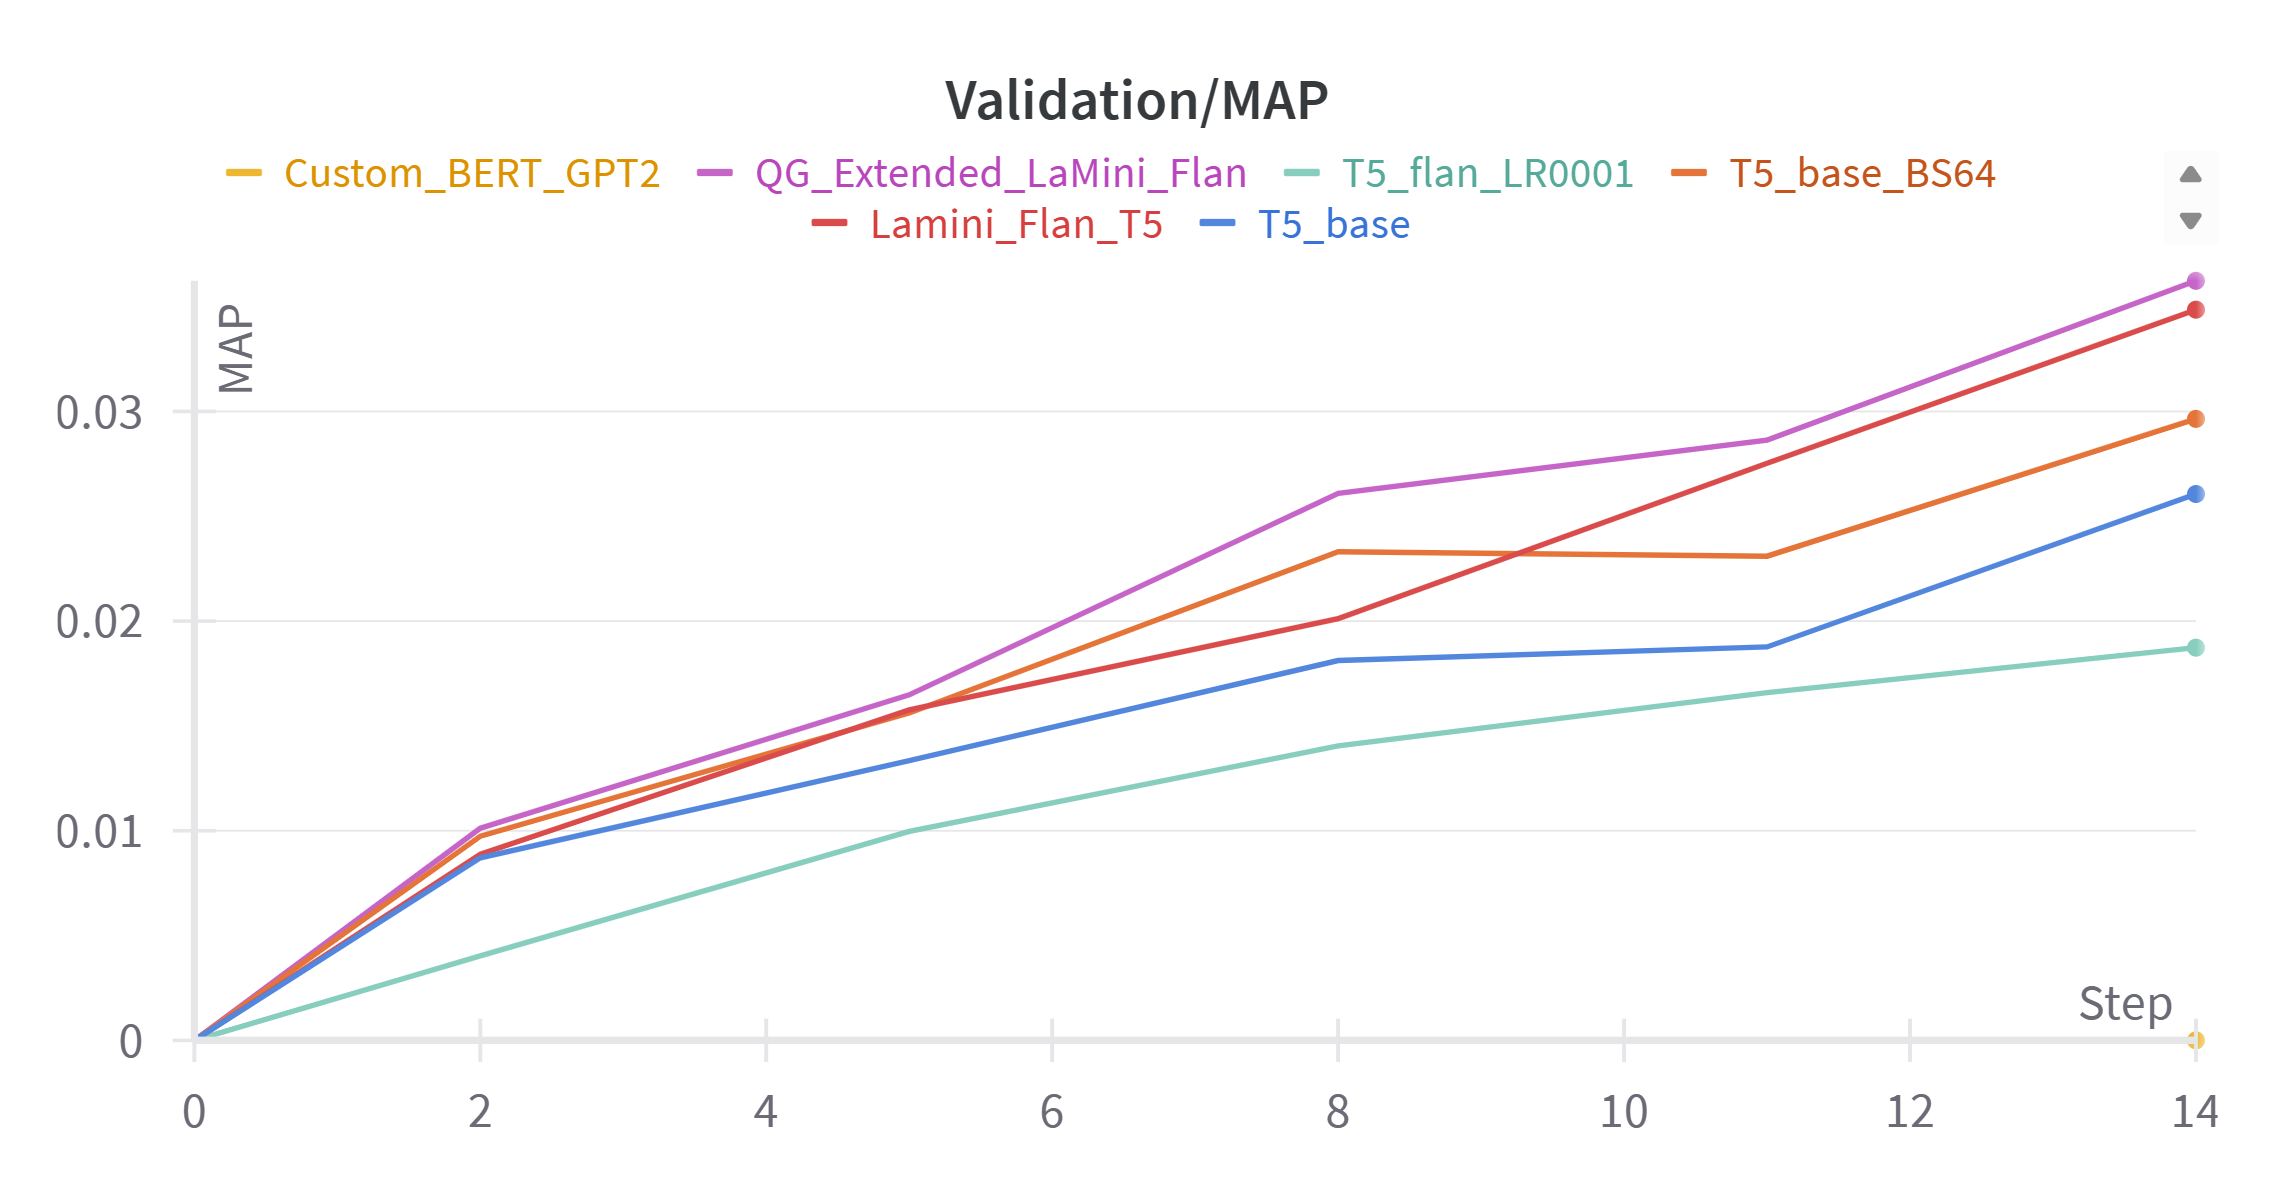

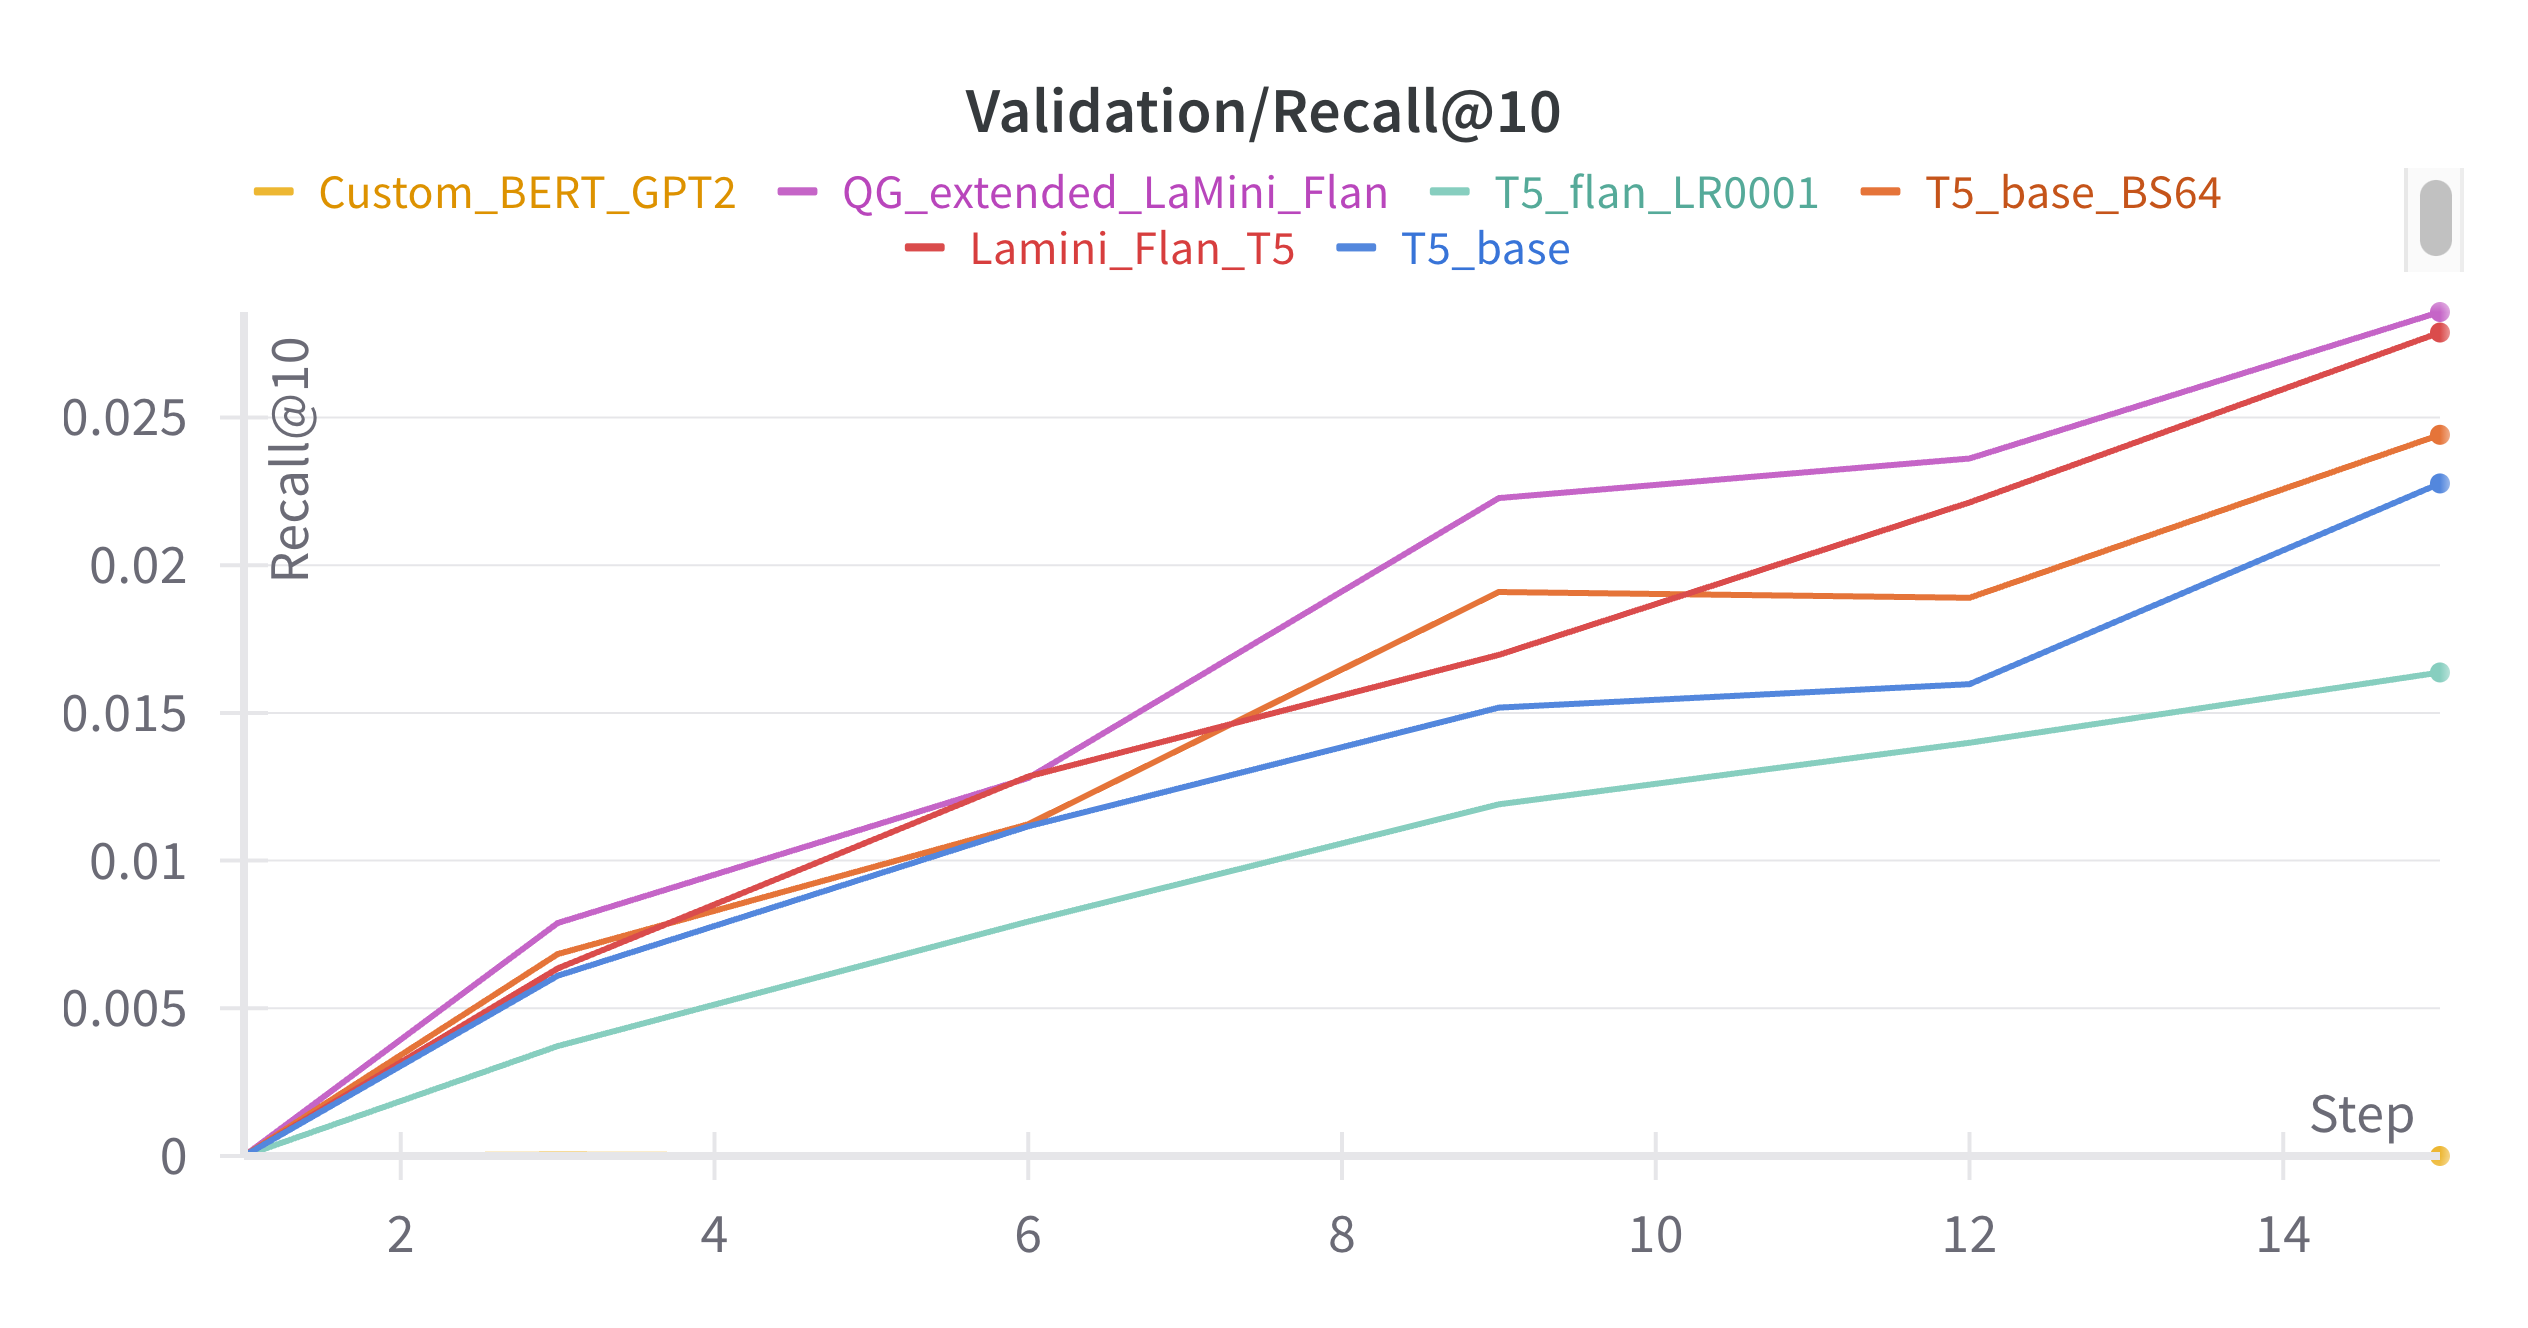

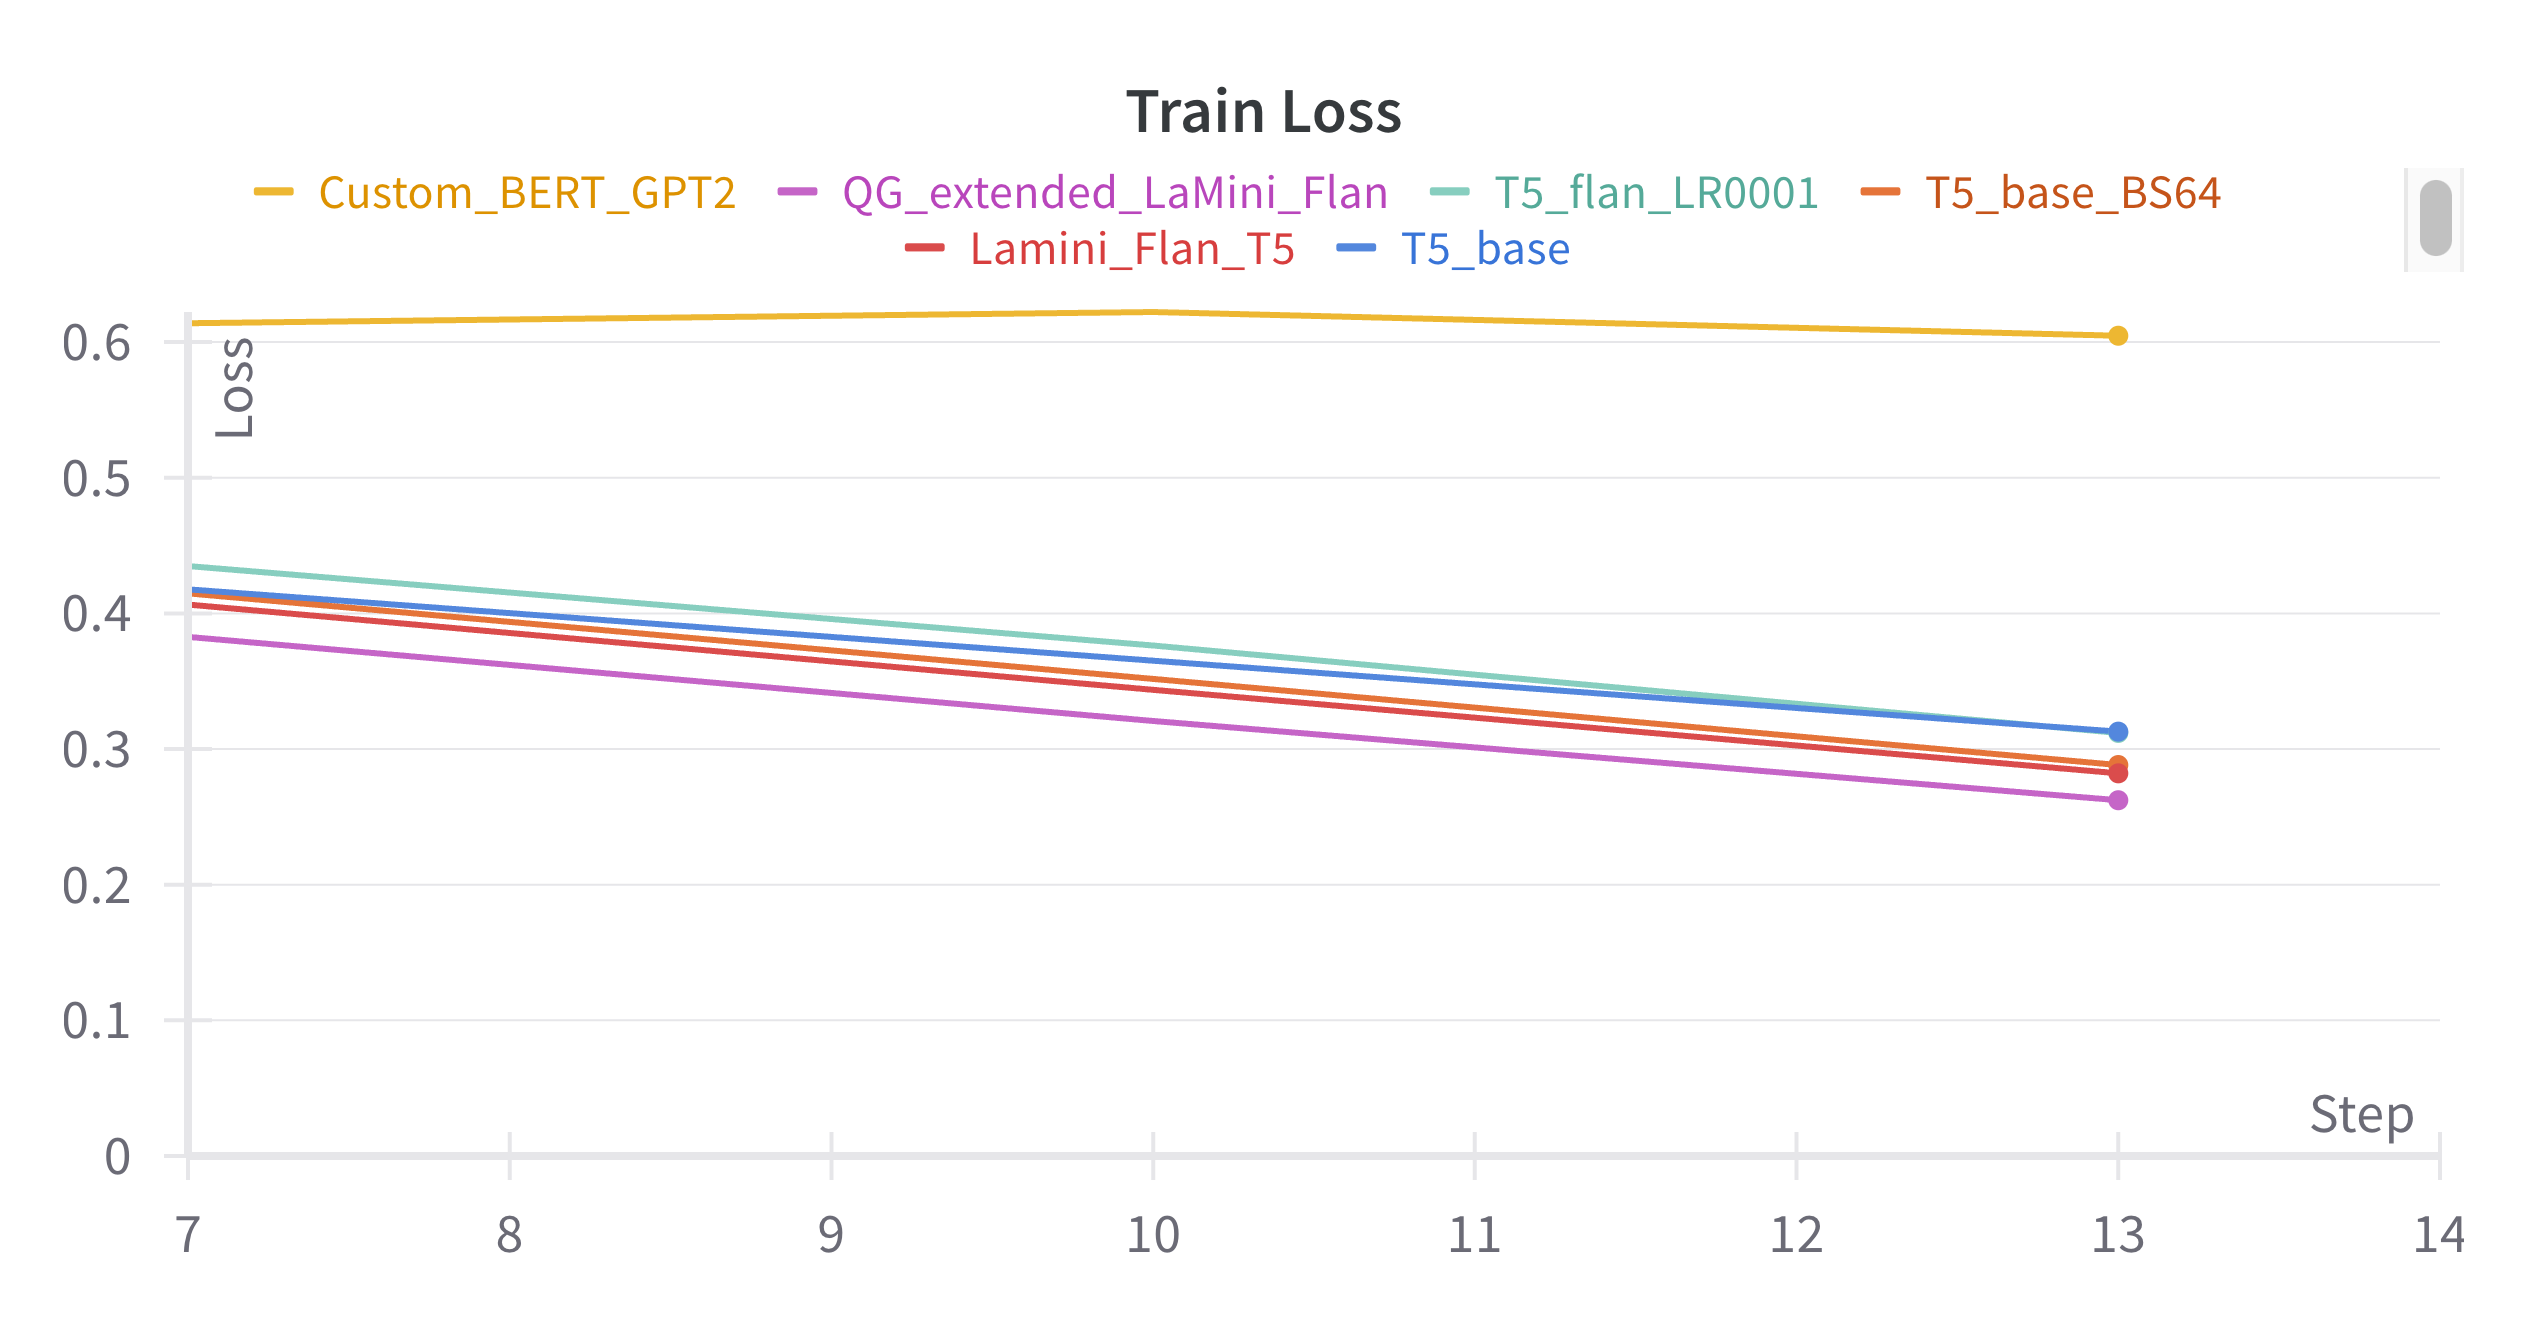

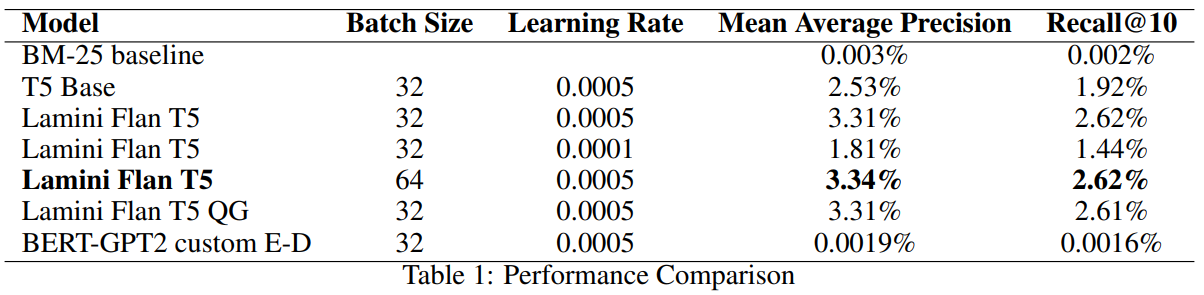